In [1]:
import numpy as np
import pandas as pd
import os
import re
import ast
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [2]:
pd.set_option('future.no_silent_downcasting', True)

def split_data_by_null(df):
   """
   Split a given DataFrame into two DataFrames based on whether the rows contain missing values or not.

   Parameters
   ----------
   df : DataFrame
      The DataFrame to be split.

   Returns
   -------
   non_null_df : DataFrame
      The DataFrame containing all the rows without missing values.
   null_df : DataFrame
      The DataFrame containing all the rows with missing values.
   """
   non_null_df = df.dropna()
   null_df = df[df.isnull().any(axis=1)]
   return non_null_df, null_df

def replace_flags_with_nan(df, flags=['N/A', '']):
   """
   Replace specified flags (e.g., 'N/A', '') in the DataFrame with np.nan.

   Parameters
   ----------
   df : pd.DataFrame
      The DataFrame containing the data to be processed.
   flags : list of str
      List of flag values to replace with np.nan (default: ['N/A', '']).

   Returns
   -------
   pd.DataFrame
      The DataFrame with flags replaced by np.nan.
   """
   # Replace flags with np.nan
   for flag in flags:
      df.replace(flag, None, inplace=True)

   return df

def clean_numeric_columns(df, numeric_columns=None):
   """
   Clean and convert columns to numeric, handling various data inconsistencies.
   
   Parameters:
   -----------
   df : pd.DataFrame
      Input DataFrame to clean
   numeric_columns : list, optional
      List of columns to clean. If None, attempts to clean all numeric-like columns.
   
   Returns:
   --------
   pd.DataFrame: Cleaned DataFrame with numeric columns
   """
   # If no columns specified, identify potential numeric columns
   if numeric_columns is None:
      numeric_columns = df.select_dtypes(include=['object']).columns

   for col in numeric_columns:
      try:
         # Remove non-numeric characters, keeping decimals
         df[col] = df[col].astype(str).apply(lambda x: re.sub(r'[^\d.]', '', x))
            
         # Convert to numeric, coercing errors to NaN
         df[col] = pd.to_numeric(df[col], errors='coerce')
      
      except Exception as e:
         print(f"Error cleaning column {col}: {e}")
   
   return df

def split_date_and_place(date_str):
   """
   Split a string in the format 'Date (Place)' into a tuple of (Date, Place)

   Parameters
   ----------
   date_str : str
      The string to be split.

   Returns
   -------
   tuple
      A tuple of (Date, Place). If the string does not match the format, returns (None, None).
   """
   if not isinstance(date_str, str) or date_str.strip().lower() == "n/a":
      return None, None
   
   match = re.match(r'^(.*\d{4}) \((.*)\)$', date_str)

   if match:
      if match.group(1) and match.group(2):
         date = match.group(1) 
         place = match.group(2)
      elif match.group(1):
         date = match.group(1)
         place = None
      elif match.group(2):
         date = None
         place = match.group(2)
      else:
         date = None
         place = None

   return date, place


def parse_duration(duration):
   """
   Parse a duration string in the format 'Xh Ym' to minutes.

   Parameters
   ----------
   duration : str
      The duration string to be parsed.

   Returns
   -------
   int
      The duration in minutes or None if the format is invalid.
   """
   if duration is not str:
      duration = str(duration)

   match = re.match(r'(?:(\d+)h)? ?(?:(\d+)m)?', duration)
   
   if match:
      hours = int(match.group(1)) if match.group(1) else 0
      minutes = int(match.group(2)) if match.group(2) else 0
      return hours * 60 + minutes
   return None

def parse_money(value):
   """
   Parse a string representing money to an integer in cents.

   Parameters
   ----------
   value : str or int
      The string to be parsed.

   Returns
   -------
   int
      The parsed value in cents or numpy.nan if the format is invalid.
   """
   if isinstance(value, str) and value.startswith('$'):
      return int(value.replace('$', '').replace(',', '').split()[0])
   return np.nan

def process_parent_guide(parent_guide):
   # Safely evaluate string to dictionary
   """
   Process a string representing a parent guide to a dictionary of features.

   Parameters
   ----------
   parent_guide : str
      The string to be processed.

   Returns
   -------
   pd.Series
      A pandas Series containing the extracted features.
   """
   guide_dict = ast.literal_eval(parent_guide)
   
   # Prepare a dictionary to hold the extracted features
   features = {}
   
   for category, details in guide_dict.items():
      # Extract features for each category
      features[f"{category}_Severity"] = details.get('Severity', None)
      features[f"{category}_Number_of_votes"] = details.get('Number of vote:', None)
            
      # Handle 'Total votes' (key mismatch handling)
      features[f"{category}_Total_votes"] = details.get('Total votes:', details.get('Total votes', None))
   
   return pd.Series(features)

def encoding(df, top_threshold):
   """
   Encode all categorical columns in a DataFrame using one-hot encoding, with multi-value columns handled
   by splitting and exploding the values.

   Parameters
   ----------
   df : pd.DataFrame
      The DataFrame to be encoded.
   top_threshold : int
      The number of top values to consider for encoding.

   Returns
   -------
   pd.DataFrame, dict
      A tuple containing the encoded DataFrame and a dictionary of encoding information.
   """
   # Define columns to exclude from encoding
   exclude_columns = ['Year', 'Duration', 'Rating', 'Number of votes', 'Critic Reviews', 
                     'Metascore', 'Budget', 'Gross Worldwide', 'Profit Margin', 'Release Date', 
                     'Popularity', 'Popularity Delta']

   data = df.copy()
   
   exclude_columns_df = data[exclude_columns].copy()
   choosed_columns = [col for col in data.columns if col not in exclude_columns]
   encoded_columns_info = {
      'top_values': {},
      'multi_value_columns': []
   }
   one_hot_columns_list = []

   for col in choosed_columns:
      column_data = data[col].astype(str)
      is_multi_value = column_data.str.contains('|').any()
      
      if is_multi_value:
         unique_values = column_data.str.split('|').explode().value_counts().head(top_threshold).index.tolist()
         encoded_columns_info['multi_value_columns'].append(col)
      else:
         unique_values = column_data.value_counts().head(top_threshold).index.tolist()
      
      encoded_columns_info['top_values'][col] = unique_values

      one_hot_cols = {}
      for val in unique_values:
         if is_multi_value:
            one_hot_cols[f"{col}_{val}"] = column_data.apply(lambda x: 1 if val in str(x).split('|') else 0)
         else:
            one_hot_cols[f"{col}_{val}"] = (column_data == val).astype(int)
      
      one_hot_df = pd.DataFrame(one_hot_cols)
      one_hot_columns_list.append(one_hot_df)

   data.drop(columns=choosed_columns, inplace=True)
   one_hot_encoded = pd.concat(one_hot_columns_list, axis=1)
   result_data = pd.concat([exclude_columns_df, data, one_hot_encoded], axis=1)

   print("Total columns after encoding:", result_data.columns)
   print("Number of encoded columns:", len(result_data.columns))

   return result_data, encoded_columns_info

from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

def predict_and_impute_metascore(data, features_to_use, max_iter=5):
   """
   Predict and impute missing `Metascore` values using predictive imputation.
   
   Parameters:
   -----------
   data : pd.DataFrame
      Input DataFrame containing the `Metascore` column and other features.
   features_to_use : list
      List of columns to use as predictors for `Metascore`.
   max_iter : int, optional
      Maximum number of iterations to refine predictions, default is 5.
   
   Returns:
   --------
   pd.DataFrame: DataFrame with missing `Metascore` values imputed.
   """
   # Create a copy of the data to avoid modifying the original DataFrame
   impute_data = data.copy()

   # Ensure the `Metascore` column exists
   if 'Metascore' not in impute_data.columns:
      raise ValueError("The `Metascore` column is not present in the DataFrame.")
   
   # Identify rows with missing and non-missing `Metascore`
   missing_mask = impute_data['Metascore'].isnull()
   complete_mask = ~missing_mask

   # Iterative predictive imputation
   for iteration in range(max_iter):
      print(f"Imputation Iteration {iteration + 1}")

      # Separate rows with and without `Metascore`
      train_data = impute_data[complete_mask]
      predict_data = impute_data[missing_mask]

      # Ensure there are rows to train on
      if train_data.empty:
         print("No complete rows available for training. Falling back to mean imputation.")
         impute_data['Metascore'] = impute_data['Metascore'].fillna(impute_data['Metascore'].mean())
         break

      # Ensure there are rows to predict
      if predict_data.empty:
         print("No missing rows to impute. Imputation complete.")
         break

      # Use features specified in `features_to_use`
      X_train = train_data[features_to_use]
      y_train = train_data['Metascore']
      X_predict = predict_data[features_to_use]

      # Split features into numeric and non-numeric (categorical) columns
      numeric_features = X_train.select_dtypes(include=['number']).columns
      categorical_features = X_train.select_dtypes(exclude=['number']).columns

      # Handle missing values in numeric features by filling with the mean
      X_train.loc[:, numeric_features] = X_train[numeric_features].fillna(X_train[numeric_features].mean())
      X_predict.loc[:, numeric_features] = X_predict[numeric_features].fillna(X_train[numeric_features].mean())

      # Optionally, handle categorical variables (e.g., using label encoding)
      if len(categorical_features) > 0:
         from sklearn.preprocessing import LabelEncoder

         for feature in categorical_features:
            le = LabelEncoder()
            X_train.loc[:, feature] = le.fit_transform(X_train[feature].astype(str))

            # For prediction data, only transform (handle unseen labels by replacing them with -1)
            X_predict.loc[:, feature] = X_predict[feature].apply(lambda x: le.transform([str(x)])[0] if str(x) in le.classes_ else -1)

         try:
            # Train a Random Forest Regressor on the complete data
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)

            predicted_values = model.predict(X_predict)
            impute_data.loc[missing_mask, 'Metascore'] = predicted_values

            # Update masks for the next iteration
            missing_mask = impute_data['Metascore'].isnull()
            complete_mask = ~missing_mask

         except Exception as e:
            # Fallback to mean imputation
            impute_data['Metascore'] = impute_data['Metascore'].fillna(impute_data['Metascore'].mean())
            break

   return impute_data


def decoding(data, encoded_columns_info):
   """
   Decodes a DataFrame from one-hot encoded categorical columns into a single column with original categorical values.

   Parameters
   ----------
   data : pd.DataFrame
      Input DataFrame to decode
   encoded_columns_info : dict
      Dictionary containing information about which columns were one-hot encoded and their top values

   Returns
   -------
   pd.DataFrame: Decoded DataFrame with original categorical columns
   """
   
   decoded_data = data.copy()

   # Get top values and multi-value columns from the info dictionary
   top_values = encoded_columns_info['top_values']
   multi_value_columns = encoded_columns_info['multi_value_columns']

   for original_col, values in top_values.items():
      relevant_columns = [col for col in data.columns if col.startswith(f"{original_col}_")]
      
      print(f"Decoding {original_col}")
      print(f"Relevant columns: {relevant_columns}")
      print(f"Top values: {values}")

      if relevant_columns:
         # Determine decoding method based on column type
         if original_col in multi_value_columns:
            # Multi-value column decoding
            def decode_multi_row(row):
               """
               Decode a row of one-hot encoded columns into a single multi-value string.

               Parameters
               ----------
               row : pd.Series or list
                  The row containing one-hot encoded values for a particular column.

               Returns
               -------
               str
                  A string of top values joined by '|' if any are present, otherwise an empty string.
               """
               present_values = [val for val, is_present in zip(values, row) if is_present]
               return '|'.join(present_values) if present_values else ''

            decoded_column = decoded_data[relevant_columns].apply(decode_multi_row, axis=1)

         else:
            # Single-value column decoding
            def decode_single_row(row):
               """
               Decode a row of one-hot encoded columns into a single categorical string.

               Parameters
               ----------
               row : pd.Series or list
                  The row containing one-hot encoded values for a particular column.

               Returns
               -------
               str
                  A string of the single present value if any are present, otherwise an empty string.
               """
               present_values = [val for val, is_present in zip(values, row) if is_present]
               return present_values[0] if present_values else ''

            decoded_column = decoded_data[relevant_columns].apply(decode_single_row, axis=1)

         decoded_column.name = original_col

         # Replace the encoded columns with the decoded column
         decoded_data[original_col] = decoded_column
         decoded_data.drop(columns=relevant_columns, inplace=True)

   return decoded_data

def encode_and_impute(data, columns_to_encode, top_threshold=200):
   """
   Safely encode categorical columns and handle missing values.
   
   Parameters:
   -----------
   data : pd.DataFrame
      Input DataFrame to be processed
   columns_to_encode : list
      List of columns to be one-hot encoded
   top_threshold : int, optional
      Number of top values to consider for encoding
   
   Returns:
   --------
   pd.DataFrame: Processed DataFrame with encoded columns
   dict: Encoding information for potential decoding
   """
   processed_data = data.copy()
   
   # Encoding information to store
   encoding_info = {
      'top_values': {},
      'multi_value_columns': []
   }
   
   # List to store one-hot encoded columns
   one_hot_columns = []
   
   # Process each column for encoding
   for col in columns_to_encode:
      # Convert to string and handle potential multi-value columns
      column_data = processed_data[col].astype(str)
      
      # Check if it's a multi-value column
      is_multi_value = column_data.str.contains('|').any()
      
      # Get unique values
      if is_multi_value:
         unique_values = column_data.str.split('|').explode().value_counts().head(top_threshold).index.tolist()
         encoding_info['multi_value_columns'].append(col)
      else:
         unique_values = column_data.value_counts().head(top_threshold).index.tolist()
      
      # Store top values
      encoding_info['top_values'][col] = unique_values
      
      # Create one-hot encoded columns
      for val in unique_values:
         if is_multi_value:
            one_hot_cols = column_data.apply(lambda x: 1 if val in str(x).split('|') else 0)
         else:
            one_hot_cols = (column_data == val).astype(int)
            
         one_hot_cols.name = f"{col}_{val}"
         one_hot_columns.append(one_hot_cols)
   
   # Remove original categorical columns and add one-hot encoded columns
   processed_data = processed_data.drop(columns=columns_to_encode)
   processed_data = pd.concat([processed_data] + one_hot_columns, axis=1)
   
   return processed_data, encoding_info

def safe_impute_missing_values(data, good_data, max_iter=5):
   """
   Safely impute missing values using multiple strategies.
   
   Parameters:
   -----------
   data : pd.DataFrame
      DataFrame with missing values to impute
   good_data : pd.DataFrame
      Reference DataFrame with complete data
   max_iter : int, optional
      Maximum number of imputation iterations
   
   Returns:
   --------
   pd.DataFrame: Imputed DataFrame
   """

   # Create a copy of the data
   impute_data = data.copy()

   # Identify columns with missing values
   columns_with_missing = impute_data.columns[impute_data.isnull().any()].tolist()

   # Separate numeric and categorical columns
   numeric_columns = impute_data.select_dtypes(include=['int64', 'float64']).columns
   categorical_columns = impute_data.select_dtypes(include=['object']).columns

   # Check if `Metascore` column is present and has missing values
   if 'Metascore' in columns_with_missing:
      print("Imputing missing values for 'Metascore' using predictive imputation...")

      features_to_use = [col for col in impute_data.columns if col != 'Metascore']

      # Call the `predict_and_impute_metascore` function then remove after predict
      impute_data = predict_and_impute_metascore(impute_data, features_to_use, max_iter=max_iter)
      columns_with_missing.remove('Metascore')

   # Iteration to improve imputation for remaining columns
   for iteration in range(max_iter):
      print(f"Imputation Iteration {iteration + 1}")

      # Impute numeric columns
      for col in numeric_columns:
         if col in columns_with_missing:
            if impute_data[col].isnull().any():
               try:
                  # Prepare features and target
                  feature_columns = [c for c in impute_data.columns if c != col]

                  # Separate complete and missing rows
                  complete_mask = impute_data[col].notnull()
                  missing_mask = impute_data[col].isnull()

                  # Ensure we have complete rows to train on
                  if complete_mask.sum() > 0:
                     X_train = impute_data.loc[complete_mask, feature_columns]
                     y_train = impute_data.loc[complete_mask, col]
                     X_predict = impute_data.loc[missing_mask, feature_columns]

                     # Use Random Forest for imputation
                     model = RandomForestRegressor(n_estimators=100, random_state=42)
                     model.fit(X_train, y_train)

                     # Predict and fill missing values
                     predicted_values = model.predict(X_predict)
                     impute_data.loc[missing_mask, col] = predicted_values

               except Exception as e:
                  # Fallback to simple mean imputation
                  impute_data[col] = impute_data[col].fillna(impute_data[col].mean())

      # Impute categorical columns
      for col in categorical_columns:
         if col in columns_with_missing:
            if impute_data[col].isnull().any():
               try:
                  # Prepare features and target
                  feature_columns = [c for c in impute_data.columns if c != col]

                  # Separate complete and missing rows
                  complete_mask = impute_data[col].notnull()
                  missing_mask = impute_data[col].isnull()

                  # Ensure we have complete rows to train on
                  if complete_mask.sum() > 0:
                     # Label encode the target column
                     le = LabelEncoder()
                     y_train_encoded = le.fit_transform(impute_data.loc[complete_mask, col])

                     X_train = impute_data.loc[complete_mask, feature_columns]
                     X_predict = impute_data.loc[missing_mask, feature_columns]

                     # Use Random Forest for imputation
                     model = RandomForestClassifier(n_estimators=100, random_state=42)
                     model.fit(X_train, y_train_encoded)

                     # Predict and fill missing values
                     predicted_encoded = model.predict(X_predict)
                     predicted_values = le.inverse_transform(predicted_encoded)
                     impute_data.loc[missing_mask, col] = predicted_values

               except Exception as e:
                  # Fallback to mode imputation
                  impute_data[col] = impute_data[col].fillna(impute_data[col].mode()[0]).astype(impute_data[col].dtype)

   return impute_data


def process_large_bad_data(bad_data, good_data, chunk_size=1000):
   """
   Process large bad_data in chunks to avoid memory issues.
   
   Parameters:
   -----------
   bad_data : pd.DataFrame
      Data with missing values to be imputed
   good_data : pd.DataFrame
      Fully preprocessed data without missing values
   chunk_size : int, optional
      Number of rows to process in each chunk (default: 1000)
   
   Returns:
   --------
   pd.DataFrame: Fully imputed data
   """
   # Reset index to avoid duplicate label issues
   bad_data = bad_data.reset_index(drop=True)
   
   # Initialize an empty DataFrame to store imputed results
   fully_imputed_data = pd.DataFrame()
   
   # Process data in chunks
   for start in range(0, len(bad_data), chunk_size):
      end = min(start + chunk_size, len(bad_data))
      print(f"Processing bad_data chunk from row {start} to {end}")
      
      # Select current chunk
      current_chunk = bad_data.iloc[start:end]
      
      # Impute current chunk
      imputed_chunk = safe_impute_missing_values(current_chunk, good_data)
      
      # Append to results
      fully_imputed_data = pd.concat([fully_imputed_data, imputed_chunk], ignore_index=True)
   
   return fully_imputed_data

def preprocessing_chunk(df):
   """
   Preprocess a given Pandas DataFrame.

   Parameters
   ----------
   df : Pandas DataFrame
      The DataFrame to be preprocessed.
   only_first_genre : bool, optional
      Whether to only consider the first genre for each movie or not (default: False).
   top_threshold : int, optional
      The number of top actors and genres to consider for one-hot encoding (default: 200).

   Returns
   -------
   good_data, bad_data : tuple of two Pandas DataFrames
      The preprocessed DataFrame is split into two parts: good_data and bad_data.
      good_data contains the preprocessed data without outliers or null values.
      bad_data contains the outliers and null values that were removed from good_data.
   """
   data = df.copy()
   good_data = pd.DataFrame()
   bad_data = pd.DataFrame()

   # Drop duplicates
   data = data.drop_duplicates()

   # Process Parental Guide
   processed_features = data['Parental Guide'].apply(process_parent_guide)
   data = pd.concat([data, processed_features], axis=1)
   data = data.drop(columns=['Parental Guide'])

   data = replace_flags_with_nan(data)
   # Drop columns with entirely null values
   data = data.drop(columns=['Type', 'Watchlist Count', 'Runtime'])

   # Convert Runtime to minutes
   data['Duration'] = data['Duration'].apply(parse_duration)

   # Split Release Date and Place
   data['Release Date'], data['Place'] = zip(*data['Release Date'].apply(split_date_and_place))

   #data['Release Year'] = pd.to_datetime(data['Release Date'], errors='coerce').dt.year

   data['Sound Mix'] = data['Sound Mix'].apply(lambda x: None if x == 'N|/|A' else x)
   
   # Parse Budget and Gross Worldwide to numeric values
   data['Budget'] = data['Budget'].apply(parse_money)
   data['Gross Worldwide'] = data['Gross Worldwide'].apply(parse_money)

   # Add Profit Margin and (? Profit Margin Ratio)
   if not data['Gross Worldwide'].isna().all() or not data['Budget'].isna().all():
      data['Profit Margin'] = data['Gross Worldwide'] - data['Budget']
      #data['Profit Margin Ratio'] = (data['Gross Worldwide'] - data['Budget']) / data['Budget']

   numeric_columns = []
   
   if numeric_columns is None:
      # Automatically detect candidate numeric columns
      numeric_columns = [
         'Year', 'Rating', 'Number of votes', 'Critic Reviews', 
         'Budget', 'Gross Worldwide'
      ]
   
   # Clean numeric columns
   data = clean_numeric_columns(data, numeric_columns)

   # Encode categorical columns
   good_data,bad_data = split_data_by_null(data)
   imputed_bad_data = process_large_bad_data(bad_data, good_data, 1000)
   
   # Identify numerical columns for outlier detection
   numerical_columns = ['Rating', 'Number of votes', 'Critic Reviews', 'Budget', 'Gross Worldwide']
   outliers = {col: good_data[col][(good_data[col] - good_data[col].mean()).abs() > 3 * data[col].std()]
               for col in numerical_columns}

   for col, outlier_values in outliers.items():
      bad_data = pd.concat([bad_data, good_data[good_data[col].isin(outlier_values)]])
      good_data = good_data[~good_data[col].isin(outlier_values)]

   return good_data, imputed_bad_data

def preprocessing(df, chunk_size, output_file_good, output_file_bad):
   """
   Process data in chunks and save each chunk incrementally to CSV files.

   Parameters
   ----------
   df : DataFrame or str
      The DataFrame or path to the CSV file containing the data to be processed.
   chunk_size : int
      Number of rows to process in each chunk.
   output_file_good : str
      File path to save the processed "good" data.
   output_file_bad : str
      File path to save the "bad" data.
   

   Notes
   -----
   Appends the results of each chunk to the output files, avoiding memory overload.
   If the output files do not exist, they will be created with headers.
   """
   # Load the data if a file path is provided
   if isinstance(df, str):
      df = pd.read_csv(df)

   total_rows = len(df)
   
   # Check if the output files exist
   good_file_exists = os.path.exists(output_file_good)
   bad_file_exists = os.path.exists(output_file_bad)

   for start in range(0, total_rows, chunk_size):
      end = min(start + chunk_size, total_rows)
      print(f"Processing rows {start} to {end}...")

      # Process the current chunk
      chunk = df.iloc[start:end]
      good_chunk, bad_chunk = preprocessing_chunk(chunk)

      # Append or create files as needed
      # For "good" data
      good_chunk.to_csv(
         output_file_good,
         mode='a',
         header=not good_file_exists,  # Write header only if the file doesn't exist
         index=False,
         encoding='utf-8'
      )
      # Update the existence status
      good_file_exists = True

      # For "bad" data
      bad_chunk.to_csv(
         output_file_bad,
         mode='a',
         header=not bad_file_exists,  # Write header only if the file doesn't exist
         index=False,
         encoding='utf-8'
      )
      
      # Update the existence status
      bad_file_exists = True

      print(f"Saved processed rows {start} to {end}.")

In [3]:
# Filling null
df = 'crawled_web_with_data_request.csv'

In [4]:
output_file_good='good_data.csv'
output_file_bad='null_filled_data.csv'
chunk_size=1000
preprocessing(df, chunk_size, output_file_good, output_file_bad)

data_all = pd.concat((pd.read_csv('good_data.csv', encoding='utf-8'), pd.read_csv('null_filled_data.csv', encoding='utf-8')), axis=0)
data_all.to_csv('all_data.csv', index=False, encoding='utf-8')

Processing rows 0 to 1000...
Processing bad_data chunk from row 0 to 530
Imputing missing values for 'Metascore' using predictive imputation...
Imputation Iteration 1
Imputation Iteration 2
No missing rows to impute. Imputation complete.
Imputation Iteration 1
Imputation Iteration 2
Imputation Iteration 3
Imputation Iteration 4
Imputation Iteration 5
Saved processed rows 0 to 1000.
Processing rows 1000 to 2000...
Processing bad_data chunk from row 0 to 526
Imputing missing values for 'Metascore' using predictive imputation...
Imputation Iteration 1
Imputation Iteration 2
No missing rows to impute. Imputation complete.
Imputation Iteration 1
Imputation Iteration 2
Imputation Iteration 3
Imputation Iteration 4
Imputation Iteration 5
Saved processed rows 1000 to 2000.
Processing rows 2000 to 3000...
Processing bad_data chunk from row 0 to 802
Imputing missing values for 'Metascore' using predictive imputation...
Imputation Iteration 1
Imputation Iteration 2
No missing rows to impute. Impu

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

before_imputation = pd.read_csv('crawled_web_with_data_request.csv', encoding='utf-8')
after_imputation = pd.read_csv('all_data.csv', encoding='utf-8')


In [6]:
# Drop columns unnessary from parental guide and adding after imputation like profit margin

after_imputation_dropped = after_imputation.drop(columns=['Sex & Nudity_Severity','Sex & Nudity_Number_of_votes','Sex & Nudity_Total_votes','Violence & Gore_Severity','Violence & Gore_Number_of_votes','Violence & Gore_Total_votes','Profanity_Severity','Profanity_Number_of_votes','Profanity_Total_votes','Alcohol, Drugs & Smoking_Severity','Alcohol, Drugs & Smoking_Number_of_votes','Alcohol, Drugs & Smoking_Total_votes','Frightening & Intense Scenes_Severity','Frightening & Intense Scenes_Number_of_votes','Frightening & Intense Scenes_Total_votes','Place', 'Profit Margin', 'Gross Worldwide','Budget','Release Date', 'Duration'])

In [7]:
before_imputation_dropped = before_imputation.drop(columns=['Runtime','Parental Guide','Type','Watchlist Count', 'Budget', 'Release Date', 'Gross Worldwide', 'Duration'])

In [8]:
print("Columns in before_imputation:", before_imputation_dropped.columns.tolist())
print("Columns in after_imputation:", after_imputation_dropped.columns.tolist())

Columns in before_imputation: ['IMDb ID', 'Director', 'Writer', 'Cast', 'Sound Mix', 'Color', 'Year', 'Certificate', 'Genre', 'Country of Origin', 'Languages', 'Production Companies', 'Filming Locations', 'Critic Reviews', 'Metascore', 'Rating', 'Number of votes', 'Popularity', 'Popularity Delta']
Columns in after_imputation: ['IMDb ID', 'Director', 'Writer', 'Cast', 'Sound Mix', 'Color', 'Year', 'Certificate', 'Genre', 'Country of Origin', 'Languages', 'Production Companies', 'Filming Locations', 'Critic Reviews', 'Metascore', 'Rating', 'Number of votes', 'Popularity', 'Popularity Delta']


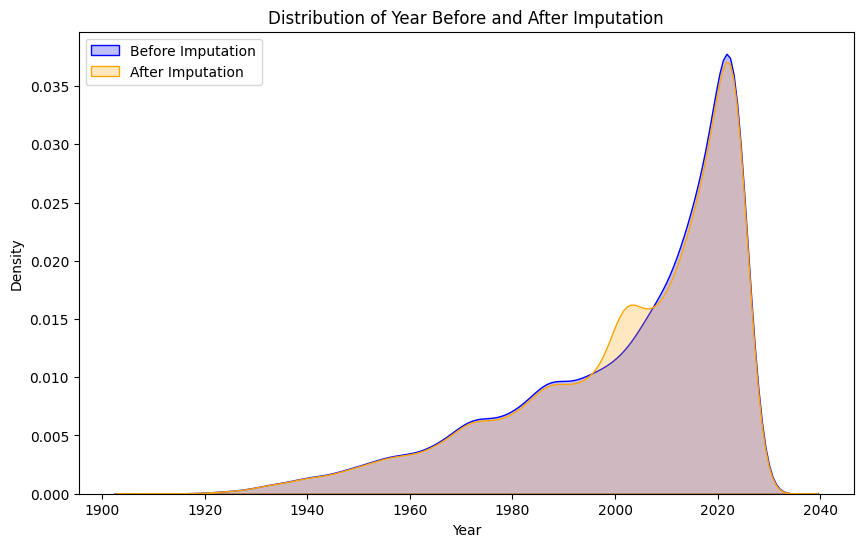

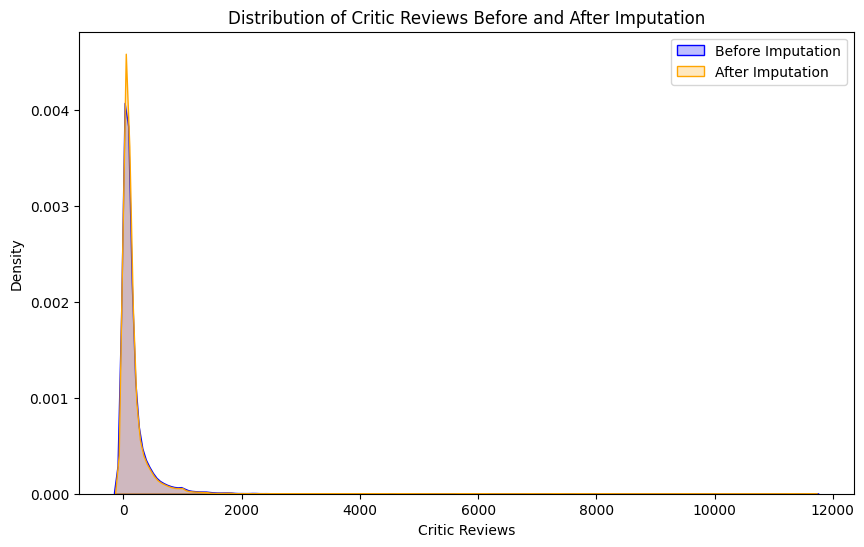

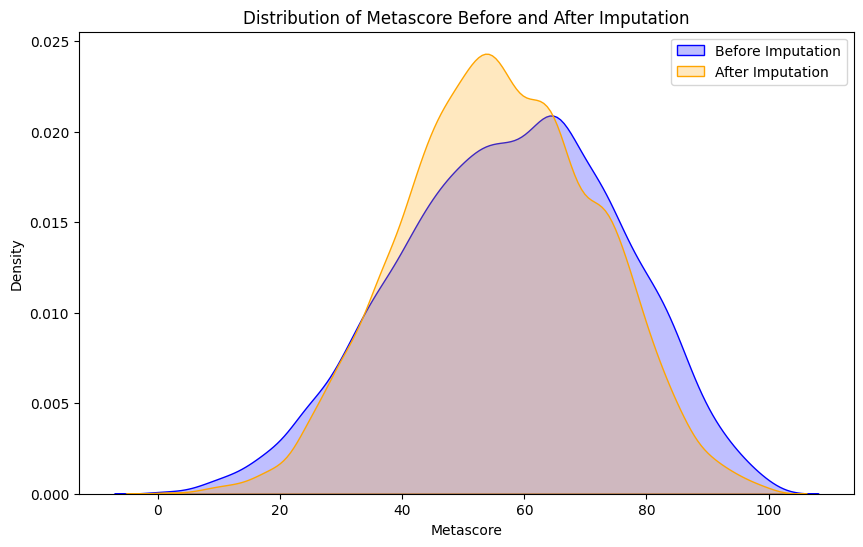

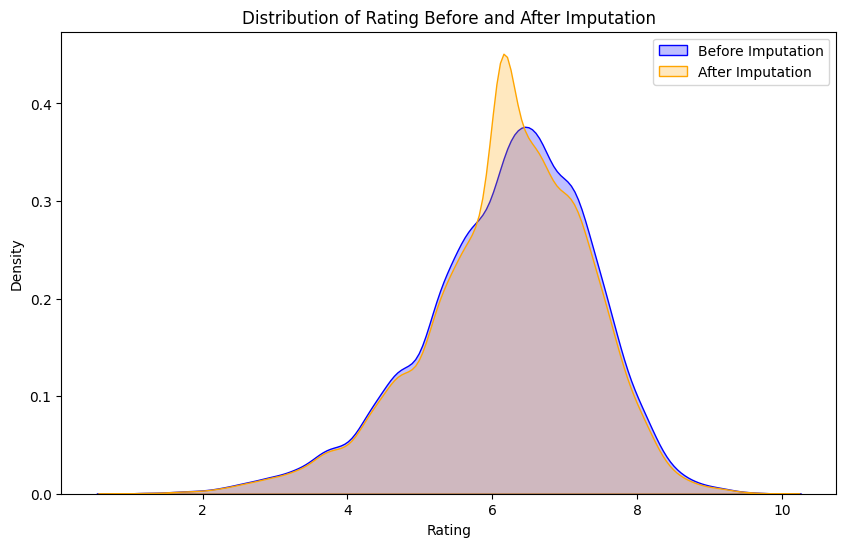

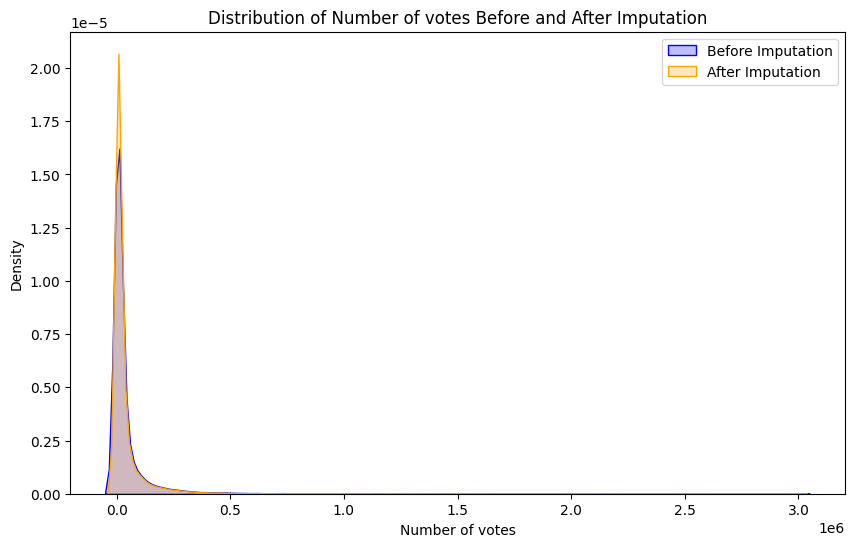

In [9]:
# Identify categorical and numeric columns
categorical_cols = before_imputation_dropped.select_dtypes(include=['object']).columns
numeric_cols = before_imputation_dropped.select_dtypes(include=['float64', 'int64']).columns

# Encode categorical columns (if needed for plotting)
encoder = LabelEncoder()
for col in categorical_cols:
    before_values = set(before_imputation_dropped[col].astype(str))
    after_values = set(after_imputation_dropped[col].astype(str))
    new_values = after_values - before_values
    if new_values:
        print(f"New categories in column '{col}' after imputation: {new_values}")
    # Encode the columns
    before_imputation_dropped[col] = encoder.fit_transform(before_imputation_dropped[col].astype(str))
    after_imputation_dropped[col] = encoder.transform(after_imputation_dropped[col].astype(str))

# Combine numeric columns for comparison (skip categorical columns for KDE)
columns_to_compare = numeric_cols.tolist()

# Plot distributions for numeric columns only
for col in columns_to_compare:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(before_imputation_dropped[col], label='Before Imputation', color='blue', fill=True)
    sns.kdeplot(after_imputation_dropped[col], label='After Imputation', color='orange', fill=True)
    plt.title(f'Distribution of {col} Before and After Imputation')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.show()